Declining  Fertility Rates
Collaborators: John Iglesias

In [82]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import json





pd.set_option("display.max_rows", 20000)


Introduction

The purpose of this project is to walk through a data science pipeline while 
exploring the world's fertility rate trends and its relationship with
global GDP (gross domestic output). Several countries around the globe have
experienced decreasing fertility rates for the past few decades which has
raised some ears

Data Processing

In [2]:

def getBirthRateData() -> pd.DataFrame:
    ''''returns df of every country's birth rate annually since 1970'''
    # Get a list of all country codes
    url = "http://api.worldbank.org/v2/country/all?per_page=500&format=json"
    response = requests.get(url)
    country_codes = [c['id'] for c in response.json()[1]]

    # Retrieve birth rate data for each country
    data = []
    for country_code in country_codes:
        url = f"http://api.worldbank.org/v2/country/{country_code}/indicator/SP.DYN.CBRT.IN"
        params = {
            "format": "json",
            "date": "1970:2020",
        }
        response = requests.get(url, params=params)
        response_json = response.json()
        # Check if the response is valid before iterating over it
        if len(response_json) > 1:
            if response_json[1]:
                for entry in response_json[1]:
                    data.append({
                        "country": entry["country"]["value"],
                        "date": entry["date"],
                        "birth_rate": entry["value"],
                    })

    # Convert the data to a pandas DataFrame
    df = pd.DataFrame(data)
    return df


In [3]:
birthDF = getBirthRateData()


In [80]:
birthDF.head(10)

,country,year,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [5]:
allCountries = set()
for country in pycountry.countries:
    allCountries.add(country.name.lower())
    
def isCountry(place):
    '''returns true if place is a country, false ow'''
    return place.lower() in allCountries
       

In [6]:
#remove rows that're not countries
birthDF = birthDF[birthDF['country'].apply(lambda x: isCountry(str(x)))]

#rename date column
birthDF = birthDF.rename(columns={'date': 'year'})

birthDF.head(10)

,country,year,birth_rate
0,Aruba,2020,8.102
1,Aruba,2019,9.138
2,Aruba,2018,9.881
3,Aruba,2017,11.530
4,Aruba,2016,12.300
5,Aruba,2015,12.428
6,Aruba,2014,13.533
7,Aruba,2013,13.316
8,Aruba,2012,12.723
9,Aruba,2011,12.246


In [7]:
def get_gdp_df():
    '''returns df of every country's gdp annually since 1970'''
    url = 'https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?per_page=20000&date=1970:2022&format=json'
    response = requests.get(url)

    # Extract JSON data from response
    data = response.json()
    df = pd.json_normalize(data[1])

    # get relevant columns
    df = df[['country.value', 'date', 'value']]
    
    # Rename columns
    df.columns = ['country', 'year', 'gdp']


    return df

gdp_df = get_gdp_df()
gdp_df.head(10)








,country,year,gdp
0,Africa Eastern and Southern,2021,1.089454e+12
1,Africa Eastern and Southern,2020,9.341791e+11
2,Africa Eastern and Southern,2019,1.009052e+12
3,Africa Eastern and Southern,2018,1.016697e+12
4,Africa Eastern and Southern,2017,1.030482e+12
5,Africa Eastern and Southern,2016,8.898593e+11
6,Africa Eastern and Southern,2015,9.231439e+11
7,Africa Eastern and Southern,2014,1.003403e+12
8,Africa Eastern and Southern,2013,9.826771e+11
9,Africa Eastern and Southern,2012,9.720022e+11


In [34]:
#remove rows that're not countries
gdp_df = gdp_df[gdp_df['country'].apply(lambda x: isCountry(str(x)))]
gdp_df.head(10)





,country,year,gdp
2548,Afghanistan,2021,1.478686e+10
2549,Afghanistan,2020,2.014344e+10
2550,Afghanistan,2019,1.890449e+10
2551,Afghanistan,2018,1.841885e+10
2552,Afghanistan,2017,1.889635e+10
2553,Afghanistan,2016,1.801956e+10
2554,Afghanistan,2015,1.999816e+10
2555,Afghanistan,2014,2.055058e+10
2556,Afghanistan,2013,2.056449e+10
2557,Afghanistan,2012,2.020357e+10


In [31]:
'''left join gdp and birth rate tables by gdp'''
df = gdp_df.merge(birthDF, on=['country', 'year'], how='left')
df.head(10)



,country,year,gdp,birth_rate
0,Afghanistan,2021,1.478686e+10,NaN
1,Afghanistan,2020,2.014344e+10,36.051
2,Afghanistan,2019,1.890449e+10,36.466
3,Afghanistan,2018,1.841885e+10,36.927
4,Afghanistan,2017,1.889635e+10,37.342
5,Afghanistan,2016,1.801956e+10,37.936
6,Afghanistan,2015,1.999816e+10,38.803
7,Afghanistan,2014,2.055058e+10,39.105
8,Afghanistan,2013,2.056449e+10,39.601
9,Afghanistan,2012,2.020357e+10,40.009


Exploratory data analysis

    Plot each country's GDP since 1970

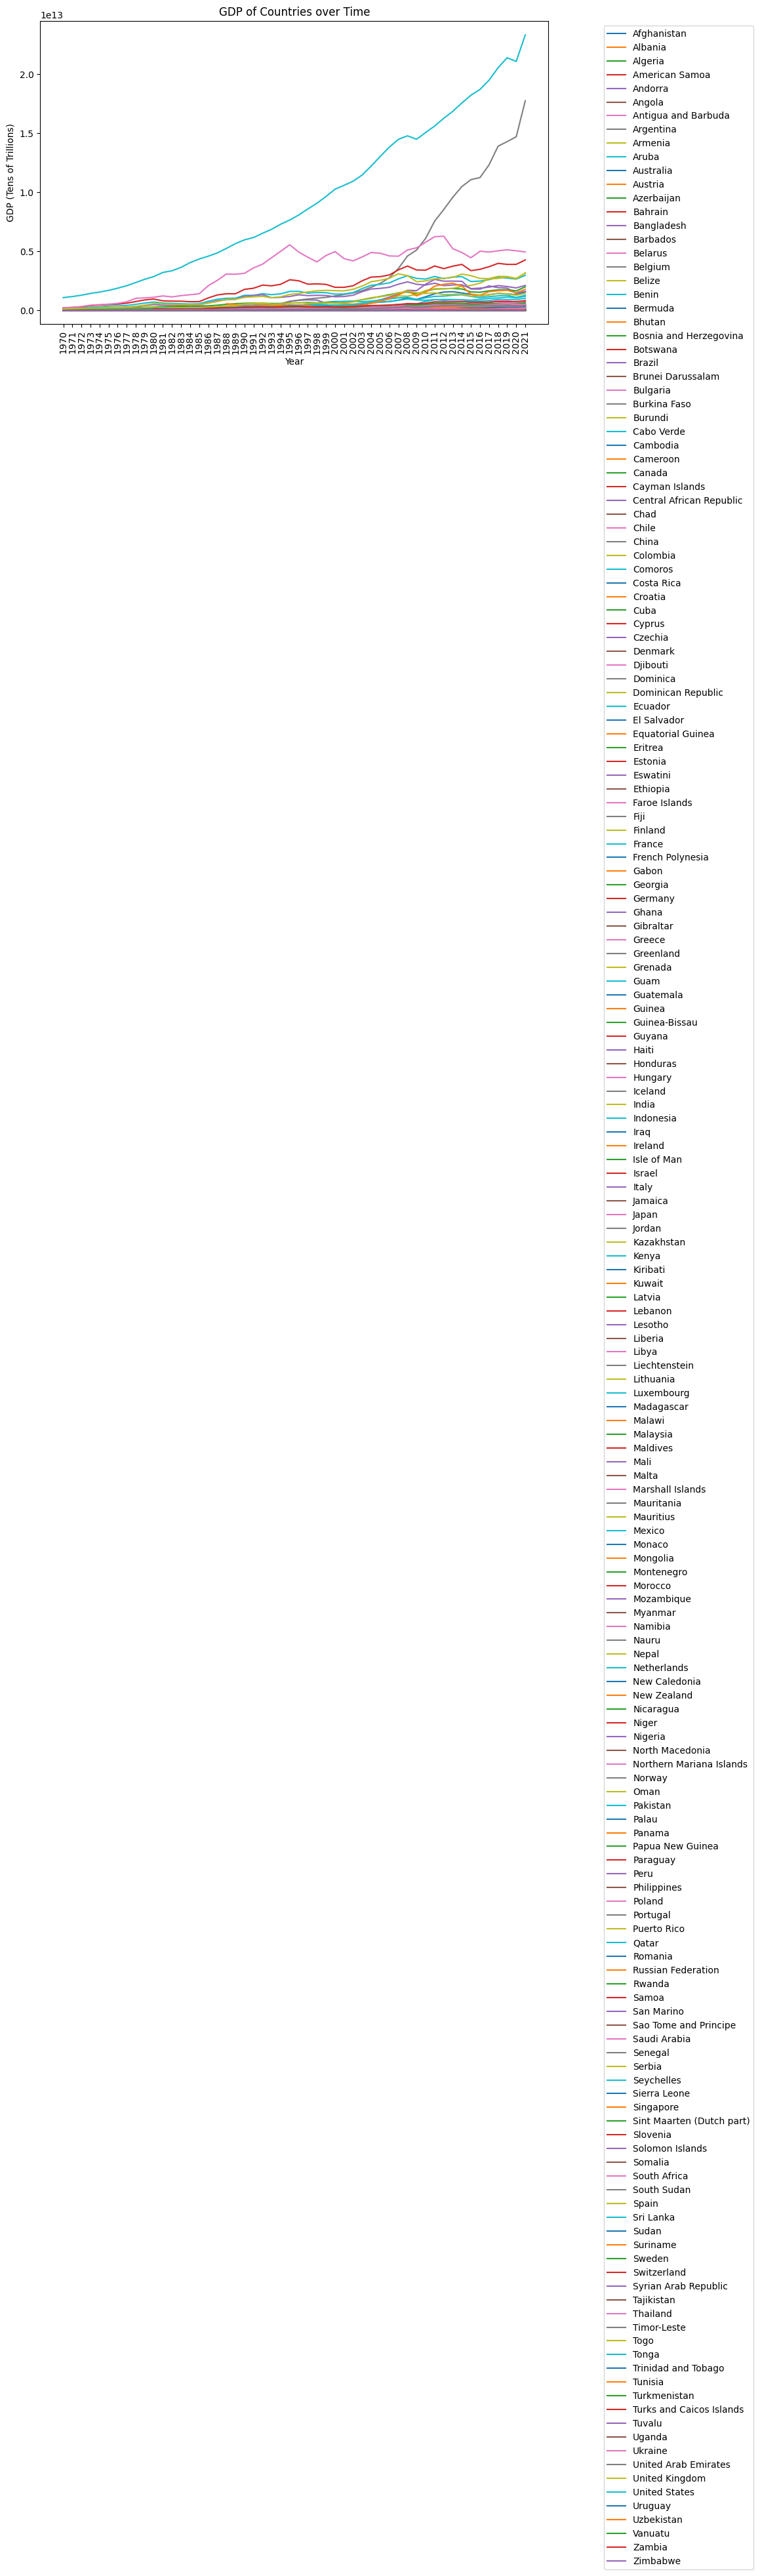

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in df.country.unique():
    sub_df = df[df.country == country]
    ax.plot(sub_df.year, sub_df.gdp, label=country)

ax.set_xlabel('Year')
ax.set_ylabel('GDP (Tens of Trillions)')
ax.set_title('GDP of Countries over Time')
ax.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
# rotate the x-ticks by 45 degrees
plt.xticks(rotation=90)
# flip the x-axis
ax.invert_xaxis()

plt.show()








As you can see, the US and China are huge GDP outliers since 1970, with the rest
 of the world's GDP staying relatively stagnant under 5  trillion dollars.

Let's narrow down the plot to better see the GDP for countries other than the US

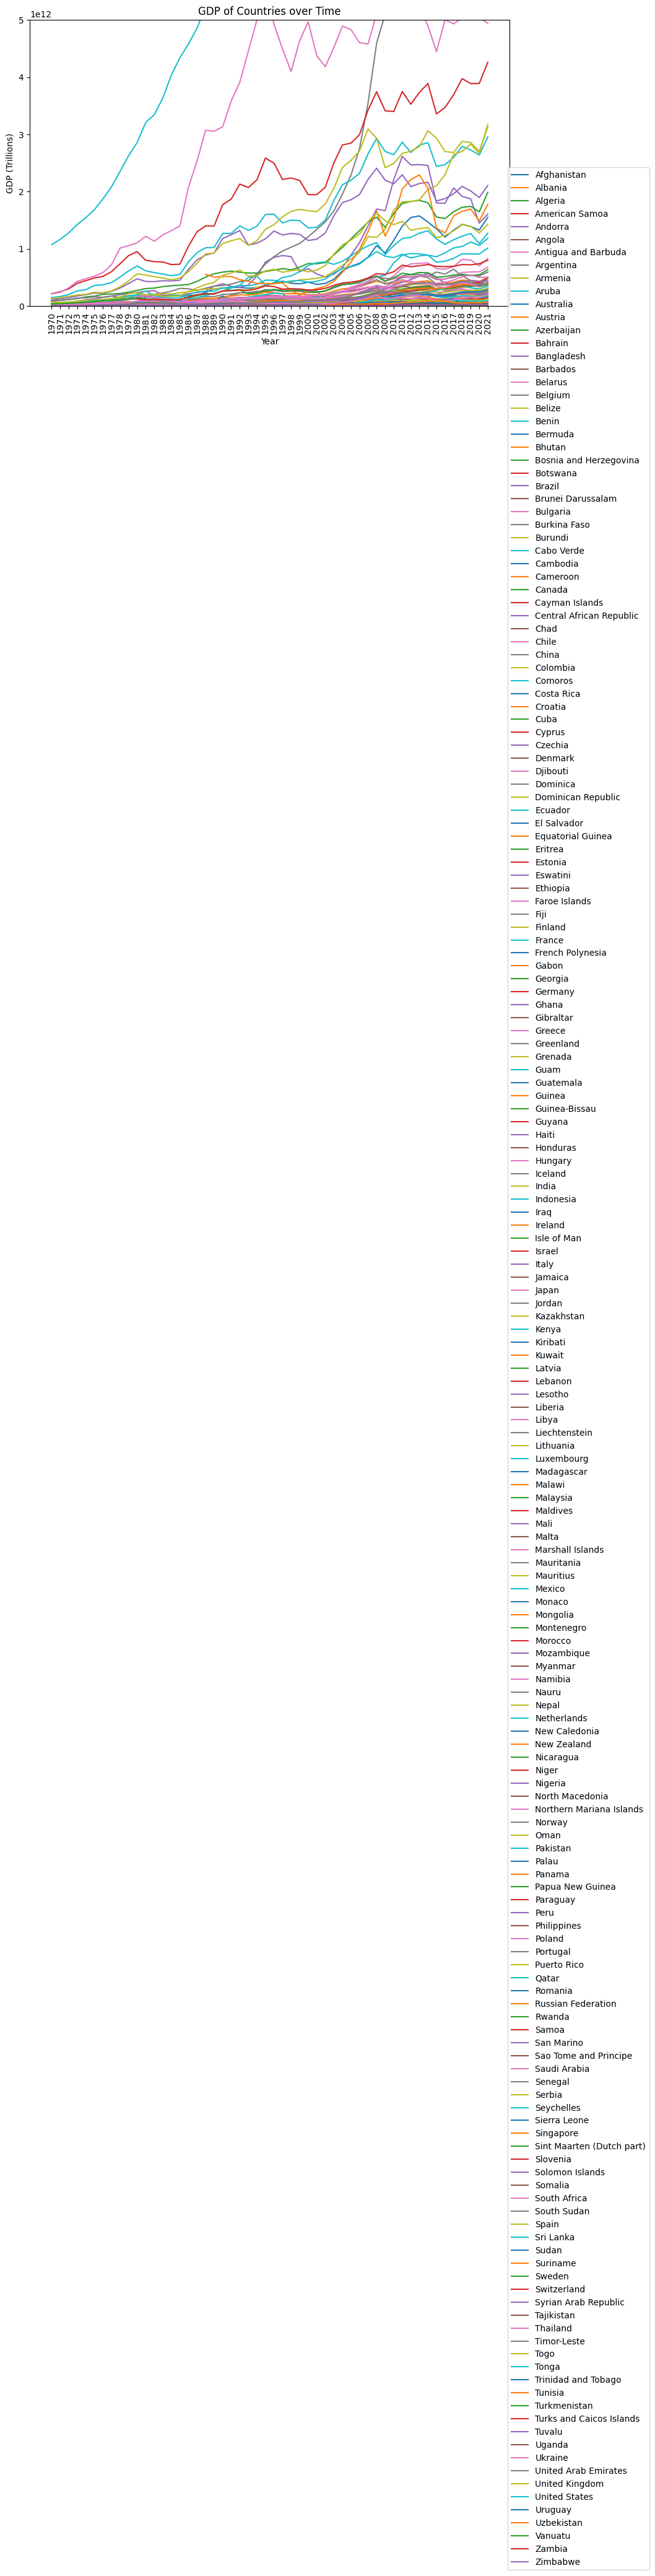

In [78]:
fig, ax = plt.subplots(figsize=(10, 6))

for country in df.country.unique():
    sub_df = df[df.country == country]
    ax.plot(sub_df.year, sub_df.gdp, label=country)

ax.set_xlabel('Year')
ax.set_ylabel('GDP (Trillions)')
ax.set_title('GDP of Countries over Time')
# adjust the right margin to make room for the legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.5))
# rotate the x-ticks by 45 degrees
plt.xticks(rotation=90)
# flip the x-axis
ax.invert_xaxis()

#adjust y-axis bounds
yBound = 5 * (10**12)
ax.set_ylim([0, yBound])




# show the plot
plt.show()

After zooming into the other country's GDP, we can see the majority
of countries have had a GDP of under 1 trillion dollars since 1970.

In [107]:
import requests
import pandas as pd

url = 'http://api.worldbank.org/v2/en/indicator/SP.DYN.CBRT.IN?downloadformat=csv'

response = requests.get(url)
data = response.content
response
# encoding = response.encoding
# data_decoded = data.decode(encoding).encode('ascii', 'ignore').decode('ascii')
# rows = data_decoded.split('\n')
# rows


<Response [200]>